<a href="https://colab.research.google.com/github/EdisonVazquezG/DeepLearning_Bourbaki/blob/main/Learning_Polynomials_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense, LSTM,Attention,Concatenate, Bidirectional,Flatten,Dropout,GRU,MultiHeadAttention,Conv1D, MaxPooling1D, Add,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping,Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix,accuracy_score
import tensorflow as tf
import multiprocessing as mp
import matplotlib.pyplot as plt
import os
from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add, Lambda, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, MultiHeadAttention, Add, LayerNormalization, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
   from google.colab import drive

   drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Scale data
def scale_data(data,scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
    else:
        scaled_data = scaler.transform(data)
    return scaled_data,scaler

In [4]:
## Reading the file

A = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Alexander_upto_17.csv")
J = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Jones_upto_15_MIRRORS.csv")
H = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/hompfly.csv")


In [5]:
############# Alexander and Jones
jones = J[~J['knot_id'].str.contains('!')]
jones = jones.drop(columns=['knot_id', 'representation','is_alternating','signature','minimum_exponent','maximum_exponent'])
jones['knot'] = jones['number_of_crossings'].astype(str) + '_' + jones['table_number'].astype(str)
jones = jones.drop(columns=['number_of_crossings','table_number'])
col = jones.pop('knot')
jones.insert(0, 'knot', col)
jones = jones.drop(columns=["knot"])

alexander = A[A["number_of_crossings"] < 16]
alexander['knot'] = alexander['number_of_crossings'].astype(str) + '_' + alexander['table_number'].astype(str)
col = alexander.pop('knot')
alexander.insert(0, 'knot', col)
alexander = alexander.drop(columns=["N/A_1","number_of_crossings","table_number","table_number","is_alternating","signature","minimum_exponent","maximum_exponent"])
alexander = alexander.drop(columns=["knot"])

A_J = pd.concat([alexander,jones],axis=1)

###### Split the data
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(alexander,jones,H,test_size=0.2,random_state=42)
X1_test, X1_val, X2_test, X2_val, y_test, y_val = train_test_split(X1_test,X2_test,y_test,test_size=0.5,random_state=42)


<ipython-input-5-098b2f98a8d5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alexander['knot'] = alexander['number_of_crossings'].astype(str) + '_' + alexander['table_number'].astype(str)


In [6]:
## Scaling
X1_train,scale_alex = scale_data(X1_train)
X2_train,scale_jones = scale_data(X2_train)

X1_test,_ = scale_data(X1_test,scaler=scale_alex)
X2_test,_ = scale_data(X2_test,scaler=scale_jones)
X1_val,_ = scale_data(X1_val,scaler=scale_alex)
X2_val,_ = scale_data(X2_val,scaler=scale_jones)

#for full predict
jones_,_ = scale_data(jones,scaler=scale_jones)
alexander_,_=scale_data(alexander,scaler=scale_alex)

## Reshape inputs to match the expected shape for LSTMs
X1_train = X1_train.reshape(-1,17,1)
X1_test = X1_test.reshape(-1,17,1)
X1_val = X1_val.reshape(-1,17,1)
X2_train = X2_train.reshape(-1,51,1)
X2_test = X2_test.reshape(-1,51,1)
X2_val = X2_val.reshape(-1,51,1)
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

## For full predict
jones_ = jones_.reshape(-1,51,1)
alexander_ = alexander_.reshape(-1,17,1)

## Create  Tensorflow datasets
def create_tf_dataset(X1,X2,y,batch_size = 32,buffer_size=1024):
    dataset = tf.data.Dataset.from_tensor_slices(((X1,X2),y))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

def create_tf_dataset_fixed(X1,X2,y,batch_size = 32,buffer_size=1024):
    dataset = tf.data.Dataset.from_tensor_slices(((X1,X2),y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset= create_tf_dataset(X1_train,X2_train,y_train)
test_dataset = create_tf_dataset(X1_test,X2_test,y_test)
val_dataset = create_tf_dataset(X1_val,X2_val,y_val)
train_dataset_fixed= create_tf_dataset_fixed(X1_train,X2_train,y_train)
test_dataset_fixed = create_tf_dataset_fixed(X1_test,X2_test,y_test)
val_dataset_fixed = create_tf_dataset_fixed(X1_val,X2_val,y_val)
full_dataset = create_tf_dataset_fixed(alexander_,jones_,H)

In [7]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:

# First input: Sequence of 17 features
input_1 = Input(shape=(17,))
x1 = Dense(128, activation='relu')(input_1)  # First dense layer
x1 = Dense(500, activation='relu')(x1)        # Second dense layer
x1 = Dense(500, activation='relu')(x1)        # Third dense layer
x1 = Dropout(0.2)(x1)
x1 = Dense(64, activation='relu')(x1)        # Fourth dense layer
x1 = Dense(17, activation='relu')(x1)        # Fifth dense layer

# Second input: 51 features
input_2 = Input(shape=(51,))
x2 = Dense(256, activation='relu')(input_2)  # First dense layer
x2 = Dense(1000, activation='relu')(x2)       # Second dense layer
x2 = Dense(1000, activation='relu')(x2)       # Third dense layer
x2 = Dropout(0.2)(x2)                       # Dropout after first layer
x2 = Dense(256, activation='relu')(x2)        # Fourth dense layer
x2 = Dense(51, activation='relu')(x2)        # Fifth dense layer

# Concatenate the two processed inputs
merged = Concatenate()([x1, x2])

# Shared dense layers after concatenation
x = Dense(500, activation='relu')(merged)
x = Dropout(0.2)(x)                        # Dropout after shared dense layer
x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x)                        # Dropout after shared dense layer

# Output layer: 152 features
output = Dense(152, activation='linear')(x)

with tf.device(device_name):
  ## The model
  model = Model(inputs = [input_1,input_2], outputs=output)
  ####### Compile and train the model
  model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error',metrics=['mse'])

## Early stopping
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

## Train the model
#history = model.fit(train_dataset,epochs=1,batch_size=32,validation_data=val_dataset,callbacks=[early_stopping,per_observation_mse_callback], verbose=1)
history = model.fit(train_dataset,epochs=100,batch_size=32,validation_data=val_dataset,callbacks=[early_stopping, reduce_lr], verbose=1)


Epoch 1/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 6.5976 - mse: 6.5976 - val_loss: 3.6537 - val_mse: 3.6537 - learning_rate: 0.0010
Epoch 2/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - loss: 4.0446 - mse: 4.0446 - val_loss: 3.1898 - val_mse: 3.1898 - learning_rate: 0.0010
Epoch 3/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 3.5132 - mse: 3.5132 - val_loss: 2.8288 - val_mse: 2.8288 - learning_rate: 0.0010
Epoch 4/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 3.2250 - mse: 3.2250 - val_loss: 2.7843 - val_mse: 2.7843 - learning_rate: 0.0010
Epoch 5/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 2.9893 - mse: 2.9893 - val_loss: 2.8192 - val_mse: 2.8192 - learning_rate: 0.0010
Epoch 6/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 3.1757 - mse: 3.1757 - val_loss: 2.4989 - val_mse: 2.4989 - learning_rate: 0.0010
Epoch 7/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 2.7305 - mse: 2.7305 - val_loss: 2.3885 - val_mse: 2.3885 - 

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Dense_Model_1.14TrainMSE_0.98Val_mse.h5')

In [ ]:

out = on_epoch_end(1)
pd.DataFrame(out).to_csv("/content/drive/MyDrive/Colab Notebooks/mse_full_dense.csv")

In [ ]:
###### Evaluate the model
y_pred = model.predict([alexander_,jones_])
y_pred_df = pd.DataFrame(y_pred)
#pd.DataFrame(out).to_csv("/content/drive/MyDrive/Colab Notebooks/mse_full_dense2.csv")
y_pred_df.to_csv("/content/drive/MyDrive/Colab Notebooks/predict_dense.csv")

9789/9789 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


In [ ]:
def compute_mse(dataset,epoch,model,dataset_type = 'train'):
    y_true_all = []
    y_pred_all = []

    for (X_batch1,X_batch2),y_batch in dataset:
        y_true_all.append(y_batch)
        y_pred_batch = model.predict_on_batch([X_batch1,X_batch2])
        y_pred_all.append(y_pred_batch)

    y_true_all = tf.concat(y_true_all,axis=0)
    y_pred_all = tf.concat(y_pred_all,axis=0)

    ## nsure tensors are of type float32
    y_true_all = tf.cast(y_true_all,tf.float32)
    y_pred_all = tf.cast(y_pred_all,tf.float32)
    mse_per_observation = tf.reduce_mean(tf.square(y_true_all-y_pred_all),axis=1)

    return mse_per_observation.numpy()

def on_epoch_end(epoch,model,logs=None):
    mse_train= compute_mse(full_dataset,epoch,model,dataset_type = 'train')
    #mse_val = self.compute_mse(self.val_dataset,epoch,dataset_type = 'val')
    return mse_train
    #np.savetxt(r"/content/drive/MyDrive/Colab Notebooks/mse_train_denseNN.csv", mse_train, delimiter=",")
    #np.savetxt(r"C:\Users\SESA626862\Documents\RL_codes\outputs_mse\Val\mse_val_" + str(epoch) + ".csv", mse_val, delimiter=",")


In [ ]:
##### Defining the model architecture

## LSTM for alexander
input1 = Input(shape=(17,1))
conv1 = Conv1D(filters=64,kernel_size=3,activation='relu',padding="same")(input1)
pool1=MaxPooling1D(pool_size=2)(conv1)
lstm1 = Bidirectional(LSTM(128,return_sequences = True))(pool1)
lstm1 = Bidirectional(GRU(128,return_sequences = True))(lstm1)
attention1 = MultiHeadAttention(num_heads=4,key_dim=128)(lstm1,lstm1)
flattened1 = Flatten()(attention1)
dense1= Dense(128,activation='relu',kernel_regularizer=l2(0.01))(flattened1)
dropout1 = Dropout(0.2)(dense1)

## LSTM for jones
input2 = Input(shape=(51,1))
conv2 = Conv1D(filters=64,kernel_size=3,activation='relu',padding="same")(input2)
pool2=MaxPooling1D(pool_size=2)(conv2)
lstm2 = Bidirectional(LSTM(128,return_sequences = True))(pool2)
lstm2 = Bidirectional(GRU(128,return_sequences = True))(lstm2)
attention2 = MultiHeadAttention(num_heads=4,key_dim=128)(lstm2,lstm2)
flattened2 = Flatten()(attention2)
dense2 = Dense(128,activation='relu',kernel_regularizer=l2(0.01))(flattened2)
dropout2 = Dropout(0.2)(dense2)

## Concatenate features
concatenated= Concatenate()([dropout1,dropout2])
dense = Dense(128,activation='relu')(concatenated)
dense = Dense(128,activation='relu')(dense)
output = Dense(152,activation='linear')(dense)

with tf.device(device_name):
  ## The model
  model = Model(inputs = [input1,input2], outputs=output)
  ####### Compile and train the model
  model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error',metrics=['mse'])

## Early stopping
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


## Initialize the custom callback with the training dataset
#per_observation_mse_callback = PerObservationMSECallback(train_dataset_fixed, val_dataset_fixed)


## Train the model
#history = model.fit(train_dataset,epochs=1,batch_size=32,validation_data=val_dataset,callbacks=[early_stopping,per_observation_mse_callback], verbose=1)
history = model.fit(train_dataset,epochs=100,batch_size=32,validation_data=val_dataset,callbacks=[early_stopping,reduce_lr], verbose=1)

model.save('/content/drive/MyDrive/Colab Notebooks/LSTM_model.h5')


Epoch 1/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 227s 27ms/step - loss: 9.3600 - mse: 9.2285 - val_loss: 6.4589 - val_mse: 6.2733 - learning_rate: 0.0010
Epoch 2/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 207s 26ms/step - loss: 6.1221 - mse: 5.9060 - val_loss: 4.6388 - val_mse: 4.3085 - learning_rate: 0.0010
Epoch 3/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 211s 27ms/step - loss: 4.3645 - mse: 4.0943 - val_loss: 3.5931 - val_mse: 3.3515 - learning_rate: 0.0010
Epoch 4/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 263s 27ms/step - loss: 3.8824 - mse: 3.6018 - val_loss: 3.2058 - val_mse: 3.0073 - learning_rate: 0.0010
Epoch 5/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 263s 27ms/step - loss: 3.5680 - mse: 3.2834 - val_loss: 3.1476 - val_mse: 2.8627 - learning_rate: 0.0010
Epoch 6/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 213s 27ms/step - loss: 3.3442 - mse: 3.0553 - val_loss: 2.7764 - val_mse: 2.5133 - learning_rate: 0.0010
Epoch 7/100
7831/7831 ━━━━━━━━━━━━━━━━━━━━ 212s 27ms/step - loss: 3.0476 - mse: 2.7828 - val_loss: 2.9213 - val_

NameError: name 'on_epoch_end' is not defined

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, MultiHeadAttention, Add, LayerNormalization, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def simple_transformer_block(inputs, num_heads, ff_dim, rate=0.2):
    """Applies a single simplified transformer block."""
    # Multi-Head Attention Layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(rate)(attention_output)

    # Add & Normalize
    out1 = Add()([inputs, attention_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    # Feed-forward network (simplified)
    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)

    # Add & Normalize
    out2 = Add()([out1, ffn_output])
    return LayerNormalization(epsilon=1e-6)(out2)

# First input: 17 features
input_1 = Input(shape=(17,))
x1 = Dense(64, activation='relu')(input_1)  # Simplified dense layer
x1 = Dense(128, activation='relu')(x1)      # Dense layer
x1 = Reshape((4, 32))(x1)  # Reshape to add time dimension

# Transformer block for first input
x1 = simple_transformer_block(x1, num_heads=4, ff_dim=64)  # Fewer heads and dimensions
x1 = GlobalAveragePooling1D()(x1)  # Flatten back to (batch_size, 128)

# Second input: 51 features
input_2 = Input(shape=(51,))
x2 = Dense(128, activation='relu')(input_2)  # Simplified dense layer
x2 = Dense(256, activation='relu')(x2)      # Dense layer
x2 = Reshape((4, 64))(x2)  # Reshape to add time dimension

# Transformer block for second input
x2 = simple_transformer_block(x2, num_heads=4, ff_dim=128)  # Fewer heads and dimensions
x2 = GlobalAveragePooling1D()(x2)  # Flatten back to (batch_size, 256)

# Concatenate the two processed inputs
merged = Concatenate()([x1, x2])

# Shared dense layers after concatenation
x = Dense(256, activation='relu')(merged)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

# Output layer: 152 features
output = Dense(152, activation='linear')(x)

# The model
model = Model(inputs=[input_1, input_2], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(train_dataset, epochs=100, batch_size=32, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr], verbose=1)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Tranformer_model.h5')

In [ ]:
###### Evaluate the model
y_pred = model.predict([alexander_,jones_])
y_pred_df = pd.DataFrame(y_pred)
#pd.DataFrame(out).to_csv("/content/drive/MyDrive/Colab Notebooks/mse_full_dense2.csv")
y_pred_df.to_csv("/content/drive/MyDrive/Colab Notebooks/predict_transformer.csv")

9789/9789 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step


In [ ]:
modelo_LSTM = load_model('/content/drive/MyDrive/Colab Notebooks/LSTM_model_0.67TrainMSE_0.728ValMSE_3.125e-05LR.h5')

In [ ]:
out = on_epoch_end(1,modelo_LSTM)
pd.DataFrame(out).to_csv("/content/drive/MyDrive/Colab Notebooks/mse_full_LSTM.csv")

In [ ]:
###### Evaluate the model
y_pred = modelo_LSTM.predict([alexander_,jones_])
y_pred_df = pd.DataFrame(y_pred)
#pd.DataFrame(out).to_csv("/content/drive/MyDrive/Colab Notebooks/mse_full_dense2.csv")
y_pred_df.to_csv("/content/drive/MyDrive/Colab Notebooks/predict_LSTM.csv")

9789/9789 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step


In [ ]:
modelo_transformer = load_model('/content/drive/MyDrive/Colab Notebooks/Tranformer_model.h5')

In [ ]:
out = on_epoch_end(1,modelo_transformer)
pd.DataFrame(out).to_csv("/content/drive/MyDrive/Colab Notebooks/mse_full_transformer.csv")

In [16]:
%pip install --upgrade wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 29.2 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.3
    Uninstalling wandb-0.18.3:
      Successfully uninstalled wandb-0.18.3


In [27]:
import json

In [31]:
# @title Default title text
import keras_tuner as kt

def build_model(hp):
    input1 = Input(shape=(17,1))
    conv1 = Conv1D(filters=hp.Choice('conv1_filters', [32, 64, 128]),
                   kernel_size=3, activation='relu', padding="same")(input1)
    pool1=MaxPooling1D(pool_size=2)(conv1)
    lstm1 = Bidirectional(LSTM(hp.Choice('lstm_units', [64, 128, 256]), return_sequences=True))(pool1)
    lstm1 = Bidirectional(GRU(hp.Choice('gru_units', [64, 128, 256]), return_sequences=True))(lstm1)
    attention1 = MultiHeadAttention(num_heads=hp.Choice('attention_heads', [2, 4, 8]), key_dim=128)(lstm1, lstm1)
    flattened1 = Flatten()(attention1)
    dense1= Dense(128,activation='relu',kernel_regularizer=l2(hp.Choice('l2_value', [0.1, 0.01])))(flattened1)
    dropout1 = Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.5]))(dense1)

    # Modelo para input2 es similar (puedes reutilizar el código).
    input2 = Input(shape=(51,1))
    conv2 = Conv1D(filters=hp.Choice('conv2_filters', [32, 64, 128]),
                   kernel_size=3, activation='relu', padding="same")(input2)
    pool2=MaxPooling1D(pool_size=2)(conv2)
    lstm2 = Bidirectional(LSTM(hp.Choice('lstm2_units', [64, 128, 256]), return_sequences=True))(pool2)
    lstm2 = Bidirectional(GRU(hp.Choice('gru2_units', [64, 128, 256]), return_sequences=True))(lstm2)
    attention2 = MultiHeadAttention(num_heads=hp.Choice('attention_heads2', [2, 4, 8]), key_dim=128)(lstm2, lstm2)
    flattened2 = Flatten()(attention2)
    dense2= Dense(128,activation='relu',kernel_regularizer=l2(hp.Choice('l2_value2', [0.1, 0.01])))(flattened2)
    dropout2 = Dropout(hp.Choice('dropout_rate2', [0.2, 0.3, 0.5]))(dense2)

    # Concatenate
    concatenated = Concatenate()([dropout1, dropout2])
    dense = Dense(128, activation='relu')(concatenated)
    dense = Dense(128, activation='relu')(dense)
    output = Dense(152, activation='linear')(dense)

    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 5e-3, 1e-4])),
                  loss='mean_squared_error', metrics=['mse'])
    return model


# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-10)

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Número de pruebas
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter_tuning')

tuner.search(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr])



Trial 5 Complete [03h 07m 02s]
val_loss: 1.1692779064178467

Best val_loss So Far: 0.9663713574409485
Total elapsed time: 19h 48m 51s
Results summary
Results in my_dir/hyperparameter_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
conv1_filters: 32
lstm_units: 64
gru_units: 64
attention_heads: 2
l2_value: 0.01
dropout_rate: 0.5
conv2_filters: 128
lstm2_units: 256
gru2_units: 128
attention_heads2: 8
l2_value2: 0.001
dropout_rate2: 0.3
lr: 0.0005
Score: 0.9663713574409485

Trial 0 summary
Hyperparameters:
conv1_filters: 64
lstm_units: 256
gru_units: 128
attention_heads: 2
l2_value: 0.001
dropout_rate: 0.3
conv2_filters: 128
lstm2_units: 64
gru2_units: 256
attention_heads2: 2
l2_value2: 0.001
dropout_rate2: 0.3
lr: 0.0005
Score: 1.0747390985488892

Trial 4 summary
Hyperparameters:
conv1_filters: 64
lstm_units: 128
gru_units: 128
attention_heads: 2
l2_value: 0.001
dropout_rate: 0.5
conv2_filters: 32
lstm2_units: 64
gru2_units: 64


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 110 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


AttributeError: 'Functional' object has no attribute 'history'

In [32]:
tuner.results_summary()

Results summary
Results in my_dir/hyperparameter_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
conv1_filters: 32
lstm_units: 64
gru_units: 64
attention_heads: 2
l2_value: 0.01
dropout_rate: 0.5
conv2_filters: 128
lstm2_units: 256
gru2_units: 128
attention_heads2: 8
l2_value2: 0.001
dropout_rate2: 0.3
lr: 0.0005
Score: 0.9663713574409485

Trial 0 summary
Hyperparameters:
conv1_filters: 64
lstm_units: 256
gru_units: 128
attention_heads: 2
l2_value: 0.001
dropout_rate: 0.3
conv2_filters: 128
lstm2_units: 64
gru2_units: 256
attention_heads2: 2
l2_value2: 0.001
dropout_rate2: 0.3
lr: 0.0005
Score: 1.0747390985488892

Trial 4 summary
Hyperparameters:
conv1_filters: 64
lstm_units: 128
gru_units: 128
attention_heads: 2
l2_value: 0.001
dropout_rate: 0.5
conv2_filters: 32
lstm2_units: 64
gru2_units: 64
attention_heads2: 4
l2_value2: 0.01
dropout_rate2: 0.3
lr: 0.001
Score: 1.1692779064178467

Trial 3 summary
Hyperparameters:
conv1_fil

In [33]:


# Obtener los mejores modelos del tuning (p.ej. los 5 mejores)
best_models = tuner.get_best_models(num_models=5)


In [34]:
#cada modelo entrenado
for i, model in enumerate(best_models):
    model.save(f"/content/drive/MyDrive/Colab Notebooks/best_model_LSTM_{i}.h5")  # Guardar los modelos entrenados como archivos .h5

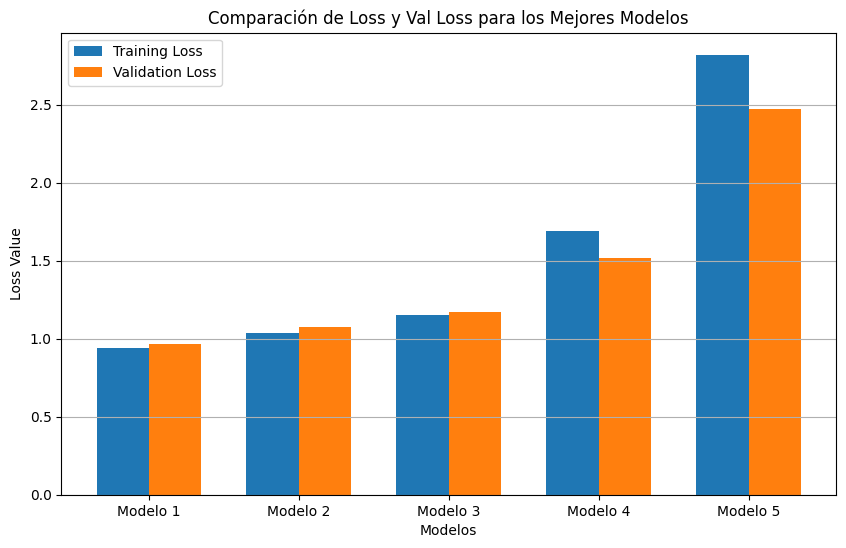

In [56]:


# Acceder a los resultados del Tuner sin necesidad de volver a entrenar
best_trials = tuner.oracle.get_best_trials(num_trials=5)


# Almacenar los valores de loss y val_loss
loss_values = []
val_loss_values = []

for trial in best_trials:
    # Obtener las métricas disponibles
    loss_history = trial.metrics.get_history('loss')
    val_loss_history = trial.metrics.get_history('val_loss')

    # Extraer el valor de MetricObservation
    loss_value = loss_history[-1].value[0]  # último valor de loss
    val_loss_value = val_loss_history[-1].value[0]  # último valor de val_loss

    loss_values.append(loss_value)
    val_loss_values.append(val_loss_value)

# Graficar los resultados finales
x = np.arange(len(loss_values))  # Para los 5 modelos
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, loss_values, width, label='Training Loss')
bars2 = ax.bar(x + width/2, val_loss_values, width, label='Validation Loss')

# Añadir etiquetas y título
ax.set_xlabel('Modelos')
ax.set_ylabel('Loss Value')
ax.set_title('Comparación de Loss y Val Loss para los Mejores Modelos')
ax.set_xticks(x)
ax.set_xticklabels([f'Modelo {i+1}' for i in range(len(loss_values))])
ax.legend()
ax.grid(axis='y')

plt.show()


In [58]:

# Crear una lista para almacenar los resultados
results = []

for i, trial in enumerate(best_trials):
    loss = trial.metrics.get_best_value('loss')
    val_loss = trial.metrics.get_best_value('val_loss')
    hyperparameters = trial.hyperparameters.values
    results.append({
        'Modelo': i + 1,
        'Mejor Pérdida': loss,
        'Mejor Pérdida de Validación': val_loss,
        'Hiperparámetros': hyperparameters
    })

results_df = pd.DataFrame(results)

|Modelo|Mejor Pérdida|Mejor Pérdida de Validación|Hiperparámetros|
|---|---|---|---|
|1|0\.9698|0\.9392|\{'conv1\_filters': 64, 'lstm\_units': 128, 'gru\_units': 128, 'attention\_heads': 4, 'l2\_value': 0\.01, 'dropout\_rate': 0\.2, 'conv2\_filters': 64, 'lstm2\_units': 128, 'gru2\_units': 128, 'attention\_heads2': 4, 'l2\_value2': 0\.01, 'dropout\_rate2': 0\.2, 'lr': 0\.000025\}|
|2|0\.9436|0\.9664|\{'conv1\_filters': 32, 'lstm\_units': 64, 'gru\_units': 64, 'attention\_heads': 2, 'l2\_value': 0\.01, 'dropout\_rate': 0\.5, 'conv2\_filters': 128, 'lstm2\_units': 256, 'gru2\_units': 128, 'attention\_heads2': 8, 'l2\_value2': 0\.001, 'dropout\_rate2': 0\.3, 'lr': 0\.0005\}|
|3|1\.0337|1\.0747|\{'conv1\_filters': 64, 'lstm\_units': 256, 'gru\_units': 128, 'attention\_heads': 2, 'l2\_value': 0\.001, 'dropout\_rate': 0\.3, 'conv2\_filters': 128, 'lstm2\_units': 64, 'gru2\_units': 256, 'attention\_heads2': 2, 'l2\_value2': 0\.001, 'dropout\_rate2': 0\.3, 'lr': 0\.0005\}|
|4|1\.1548|1\.1692|\{'conv1\_filters': 64, 'lstm\_units': 128, 'gru\_units': 128, 'attention\_heads': 2, 'l2\_value': 0\.001, 'dropout\_rate': 0\.5, 'conv2\_filters': 32, 'lstm2\_units': 64, 'gru2\_units': 64, 'attention\_heads2': 4, 'l2\_value2': 0\.01, 'dropout\_rate2': 0\.3, 'lr': 0\.001\}|
|5|1\.6901|1\.5159|\{'conv1\_filters': 64, 'lstm\_units': 128, 'gru\_units': 64, 'attention\_heads': 4, 'l2\_value': 0\.01, 'dropout\_rate': 0\.5, 'conv2\_filters': 32, 'lstm2\_units': 128, 'gru2\_units': 256, 'attention\_heads2': 8, 'l2\_value2': 0\.001, 'dropout\_rate2': 0\.2, 'lr': 0\.0001\}|
|6|2\.8199|2\.4750|\{'conv1\_filters': 32, 'lstm\_units': 256, 'gru\_units': 256, 'attention\_heads': 2, 'l2\_value': 0\.001, 'dropout\_rate': 0\.3, 'conv2\_filters': 32, 'lstm2\_units': 64, 'gru2\_units': 256, 'attention\_heads2': 4, 'l2\_value2': 0\.01, 'dropout\_rate2': 0\.5, 'lr': 0\.001\}|

{'conv1_filters': 64, 'lstm_units': 128, 'gru_units': 128, 'attention_heads': 4, 'l2_value': 0.01, 'dropout_rate': 0.2, 'conv2_filters': 64, 'lstm2_units': 128, 'gru2_units': 128, 'attention_heads2': 4, 'l2_value2': 0.01, 'dropout_rate2': 0.2, 'lr': 0.000025}
Loss: 0.9698 - mse: 0.9117 - val_loss: 0.9392 - val_mse: 0.8818


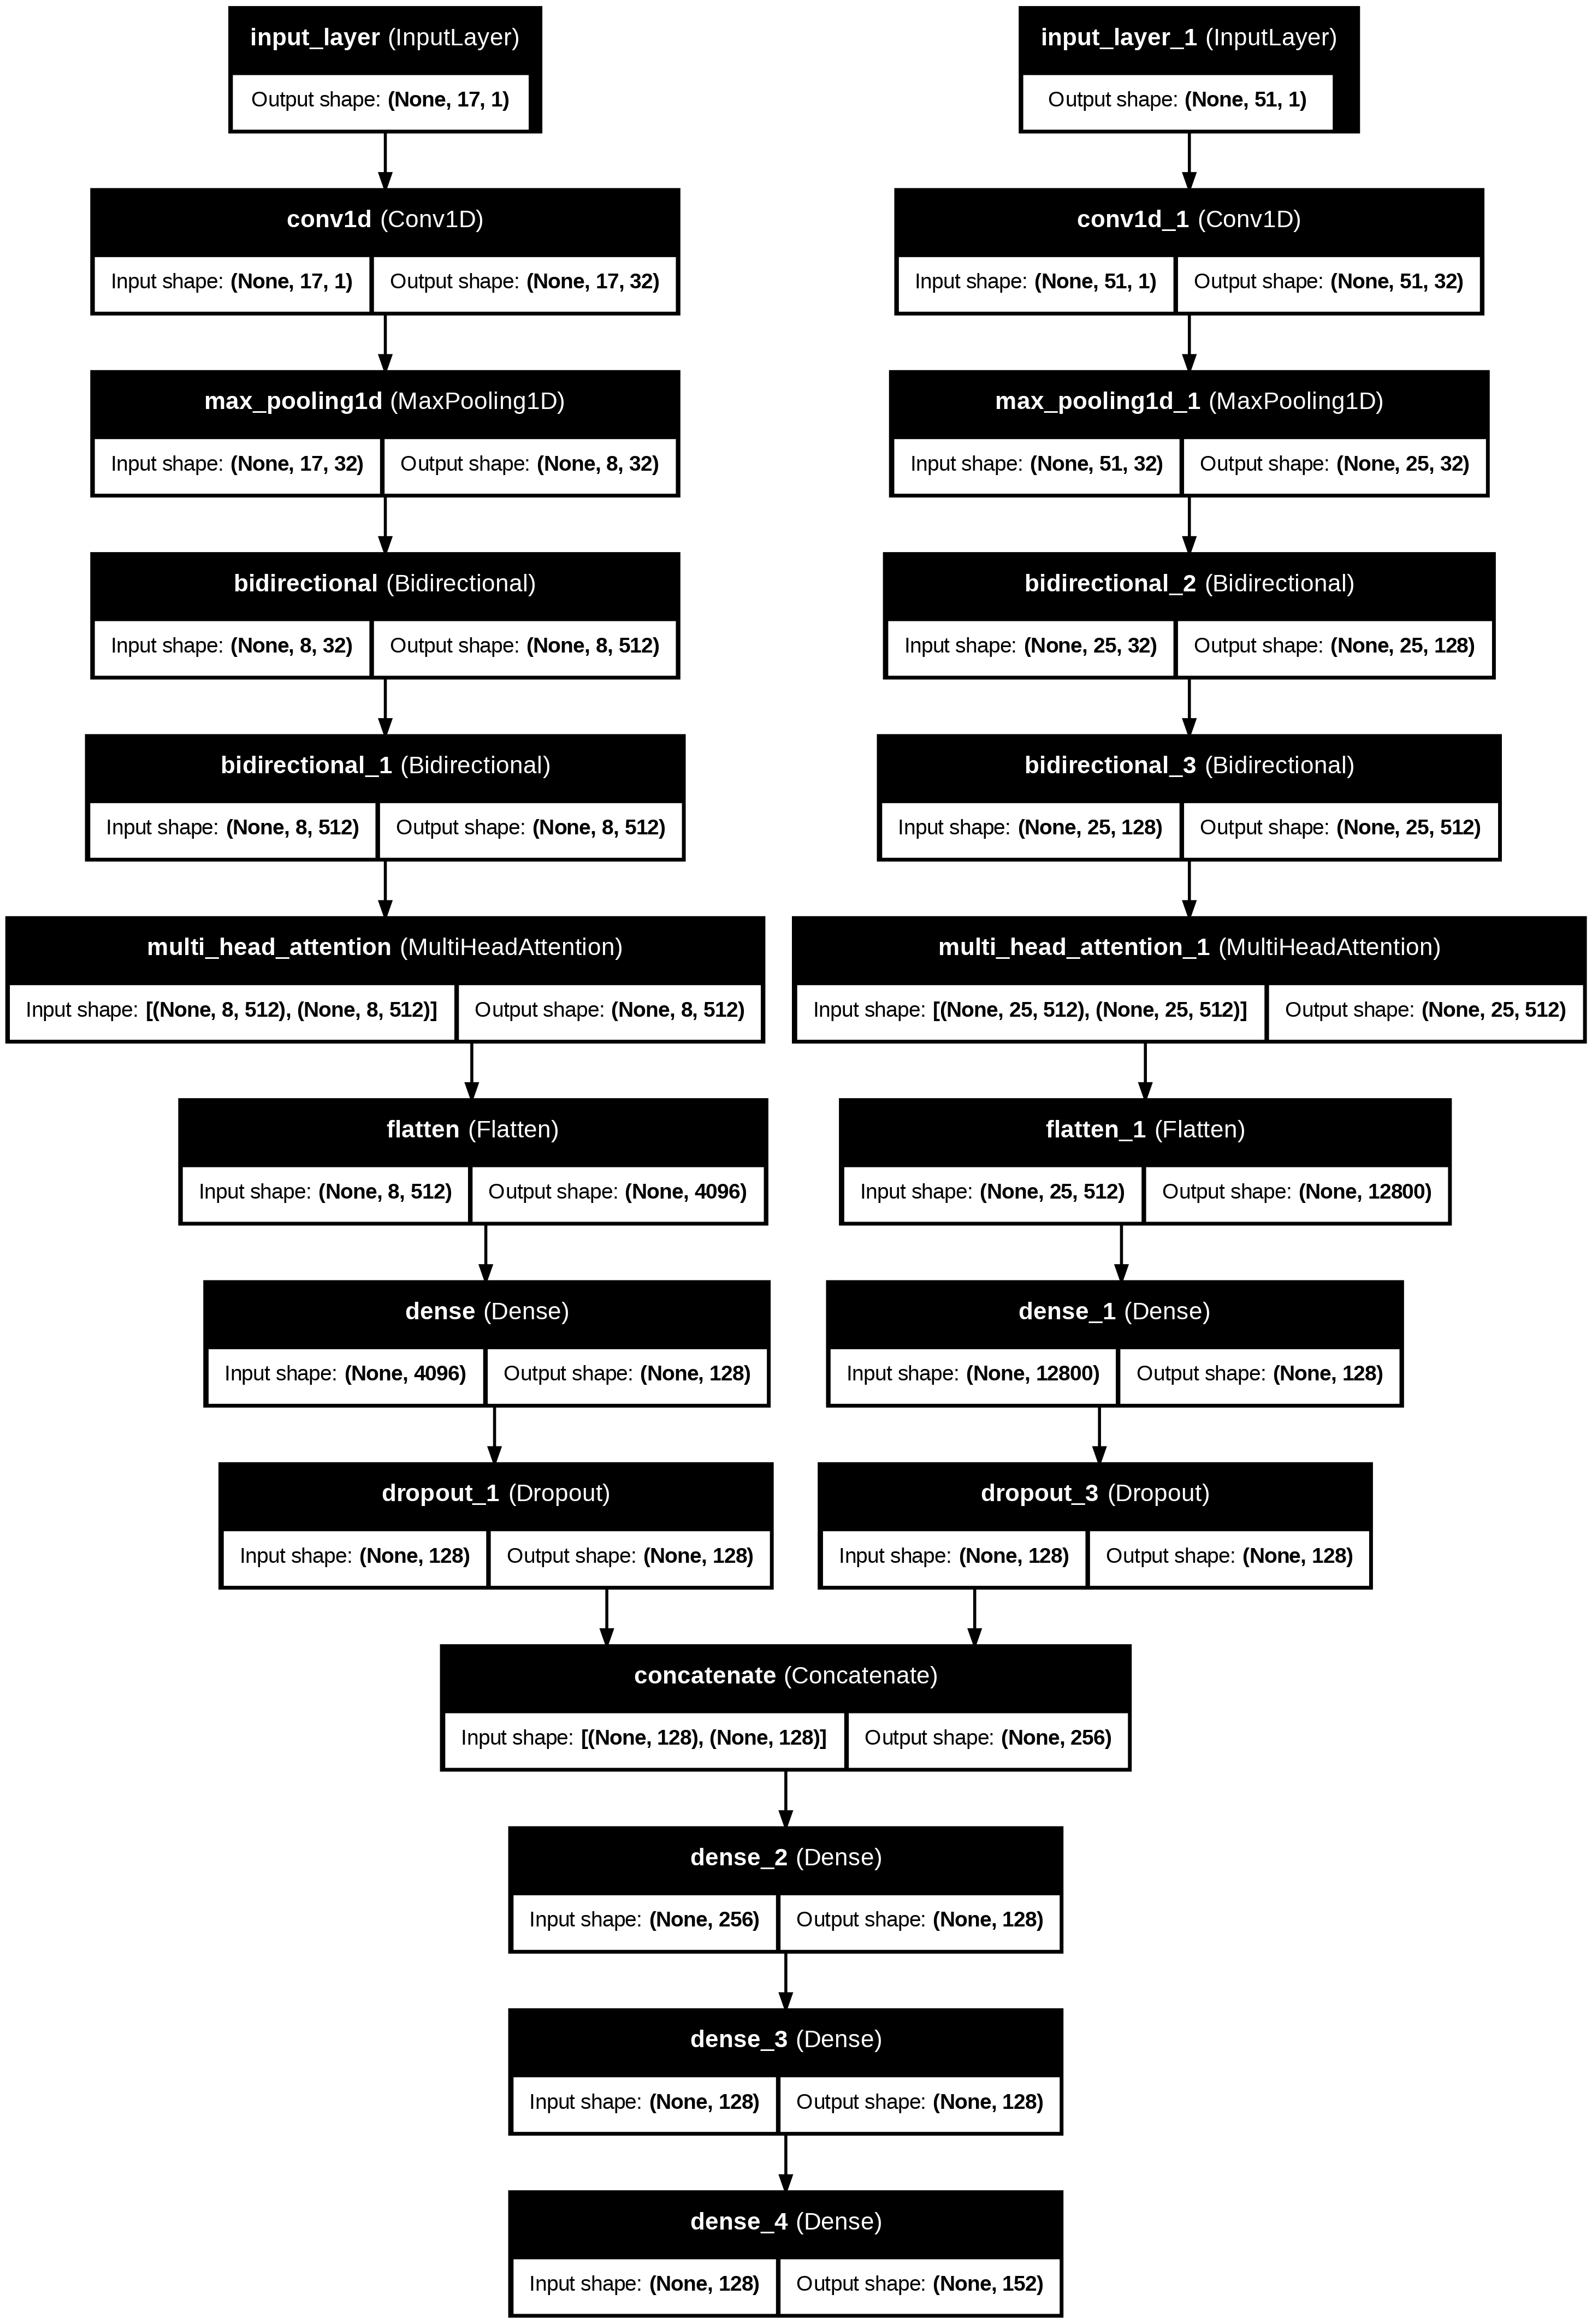

In [60]:
from tensorflow.keras.utils import plot_model

# Generar la imagen de la arquitectura
plot_model(model, to_file='arquitectura_modelo.png', show_shapes=True, show_layer_names=True)